In [2]:
%pip install requests

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
%pip install bs4


Note: you may need to restart the kernel to use updated packages.


In [4]:
import requests
from bs4 import BeautifulSoup
import json
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

# AllRecipes Cuisine A-Z Page
base_url = "https://www.allrecipes.com/cuisine-a-z-6740455"

# Headers to mimic a real browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Create the recipes directory
os.makedirs("recipes", exist_ok=True)

# Fetch the Cuisine A-Z Page
response = requests.get(base_url, headers=headers)

if response.status_code == 200:
    print("✅ Successfully fetched the Cuisine A-Z page!")
    soup = BeautifulSoup(response.text, "html.parser")

    # Find all cuisine links
    cuisine_links = {
        cuisine.text.strip(): cuisine.get("href")
        for cuisine in soup.find_all("a", class_="mntl-link-list__link")
    }

    print(f"✅ Found {len(cuisine_links)} cuisines!")

    def scrape_recipe(recipe_url, cuisine_name):
        """Fetch and parse individual recipe pages"""
        try:
            recipe_response = requests.get(recipe_url, headers=headers, timeout=10)
            if recipe_response.status_code != 200:
                print(f"❌ Failed to fetch {recipe_url} (Status: {recipe_response.status_code})")
                return None

            recipe_soup = BeautifulSoup(recipe_response.text, "html.parser")

            # Extract title
            title_element = recipe_soup.find("h1", class_="article-heading")
            title = title_element.text.strip() if title_element else "Unknown Title"

            # Extract ingredients
            ingredients = []
            for ingredient in recipe_soup.find_all("li", class_="mm-recipes-structured-ingredients__list-item"):
                quantity = ingredient.find("span", attrs={"data-ingredient-quantity": True})
                unit = ingredient.find("span", attrs={"data-ingredient-unit": True})
                name = ingredient.find("span", attrs={"data-ingredient-name": True})

                quantity_text = quantity.text.strip() if quantity else ""
                unit_text = unit.text.strip() if unit else ""
                name_text = name.text.strip() if name else ""

                full_ingredient = f"{quantity_text} {unit_text} {name_text}".strip()
                ingredients.append(full_ingredient)

            # Extract category

            return {
                "title": title,
                "ingredients": ingredients,
                "cuisine": cuisine_name,
            }

        except Exception as e:
            print(f"⚠️ Error scraping {recipe_url}: {e}")
            return None

    def scrape_cuisine(cuisine_name, cuisine_url):
        """Fetch all recipes for a given cuisine"""
        print(f"\n🍽️ Scraping cuisine: {cuisine_name}")

        try:
            cuisine_response = requests.get(cuisine_url, headers=headers, timeout=10)
            if cuisine_response.status_code != 200:
                print(f"❌ Failed to fetch {cuisine_url} (Status: {cuisine_response.status_code})")
                return

            cuisine_soup = BeautifulSoup(cuisine_response.text, "html.parser")
            recipe_links = [
                recipe.get("href")
                for recipe in cuisine_soup.find_all("a", class_="mntl-card-list-items")
            ]

            print(f"📌 Found {len(recipe_links)} recipes for {cuisine_name}")

            # Use threading to fetch multiple recipes in parallel
            recipes = []
            with ThreadPoolExecutor(max_workers=50) as executor:
                future_to_recipe = {executor.submit(scrape_recipe, url, cuisine_name): url for url in recipe_links}

                for future in as_completed(future_to_recipe):
                    recipe = future.result()
                    if recipe:
                        recipes.append(recipe)

            # Save to JSON
            file_path = f"recipes/{cuisine_name}.json"
            with open(file_path, "w") as f:
                json.dump(recipes, f, indent=4)

            print(f"✅ Successfully saved {len(recipes)} recipes for {cuisine_name} cuisine!")

        except Exception as e:
            print(f"⚠️ Error scraping cuisine {cuisine_name}: {e}")

    # Use threading to scrape multiple cuisines at the same time
    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_cuisine = {executor.submit(scrape_cuisine, name, url): name for name, url in cuisine_links.items()}

        for future in as_completed(future_to_cuisine):
            future.result()  # Ensure any exceptions are raised

    print("🎉 All cuisines scraped successfully!")

else:
    print(f"❌ Failed to fetch the Cuisine A-Z page. Status Code: {response.status_code}")


✅ Successfully fetched the Cuisine A-Z page!
✅ Found 49 cuisines!

🍽️ Scraping cuisine: Amish and Mennonite

🍽️ Scraping cuisine: Argentinian

🍽️ Scraping cuisine: Australian and New Zealander

🍽️ Scraping cuisine: Austrian

🍽️ Scraping cuisine: Bangladeshi

🍽️ Scraping cuisine: Belgian

🍽️ Scraping cuisine: Brazilian

🍽️ Scraping cuisine: Cajun and Creole

🍽️ Scraping cuisine: Canadian

🍽️ Scraping cuisine: Chilean
📌 Found 6 recipes for Belgian
📌 Found 12 recipes for Bangladeshi
📌 Found 22 recipes for Chilean
📌 Found 32 recipes for Argentinian📌 Found 22 recipes for Austrian

📌 Found 67 recipes for Brazilian
📌 Found 63 recipes for Amish and Mennonite
📌 Found 67 recipes for Canadian
📌 Found 67 recipes for Cajun and Creole
📌 Found 65 recipes for Australian and New Zealander
✅ Successfully saved 6 recipes for Belgian cuisine!

🍽️ Scraping cuisine: Chinese
📌 Found 71 recipes for Chinese
✅ Successfully saved 22 recipes for Chilean cuisine!

🍽️ Scraping cuisine: Colombian
✅ Successfully save

In [5]:
import os
import json
import pandas as pd

# Folder containing JSON files
recipe_folder = "recipes"

# Load all cuisines into a DataFrame
all_recipes = []

for file in os.listdir(recipe_folder):
    file_path = os.path.join(recipe_folder, file)
    with open(file_path, "r") as f:
        data = json.load(f)
        all_recipes.extend(data)

# Convert to DataFrame
df = pd.DataFrame(all_recipes)

# Show basic info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2457 entries, 0 to 2456
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        2457 non-null   object
 1   ingredients  2457 non-null   object
 2   cuisine      2457 non-null   object
dtypes: object(3)
memory usage: 57.7+ KB
None
                                       title  \
0                Pennsylvania Dutch Corn Pie   
1  Pennsylvania-Dutch Pickled Beets and Eggs   
2                             Amish Yumazuti   
3             Lower Fat Amish Macaroni Salad   
4            Kimberly's Curried Deviled Eggs   

                                         ingredients              cuisine  
0  [1 large potato, peeled and chopped, 1 (15 oun...  Amish and Mennonite  
1  [8 large eggs, 2 (15-ounce) cans whole pickled...  Amish and Mennonite  
2  [1 pound ground beef, 1  onion, chopped, ¾ cup...  Amish and Mennonite  
3  [1 (12 ounce) package elbow macaroni, 4  hard-.

In [6]:
# Drop duplicates based on title & cuisine
df = df.drop_duplicates(subset=["title", "cuisine"])

# Fill missing values
df["ingredients"] = df["ingredients"].apply(lambda x: x if isinstance(x, list) else [])

print(f"✅ Data cleaned! {len(df)} unique recipes remain.")


✅ Data cleaned! 2456 unique recipes remain.


In [7]:
import re

# Expanded list of words to remove
words_to_remove = [
    "baked", "grilled", "boiled", "roasted", "fried", "sauteed", "steamed", "chopped", "diced", "minced", "shredded",
    "unsalted", "salted", "fresh", "organic", "large", "small", "medium", "crushed", "ground", "whole", "peeled", "packed",
    "sliced", "cooked", "drained", "softened", "melted", "lightly", "beaten", "frozen", "skinless", "boneless",
    "halved", "quartered", "thawed", "extra", "virgin", "rinsed", "patted", "dry","dried", "finely", "coarsely", "cubed",
    "seeded", "cored", "zested", "deseeded", "trimmed", "lean", "fat", "pitted", "at", "room", "temperature", "cut", "into", "pieces",
    "left", "on", "and", "deveined", "divided", "prepared", "purpose","uncooked", "for", "frying","or","to taste", "plus", "more" ,"as", "needed", "to degrees f", "a", "ab", "about"
]

measurements = [
    "can", "cans", "package","pinch","pinches", "inch", "inches", "--","packages", "jar", "jars", "cup", "cups", "tablespoon", "tablespoons", "teaspoon", "teaspoons", "pound", "pounds", "quart", "quarts", "ounce", "ounces"
]

words_to_remove.extend(measurements)

def clean_ingredient(ingredient):
    if not ingredient or not isinstance(ingredient, str):
        return ""  # Ignore empty values
    
    # Remove everything indide () brackets
    iteration = 1
    while "(" in ingredient:
        print(f"Iteration {iteration}: {ingredient}")
        ingredient = re.sub(r"\(.*?\)", "", ingredient)  # Remove innermost brackets
        ingredient = re.sub(r"\(.*", "", ingredient)
        # # Remove any remaining unmatched brackets
        # ingredient = re.sub(r"\[|\]", "", ingredient)
        iteration += 1

    # Remove punctuation
    ingredient = re.sub(r"[.,\"\/]", "", ingredient)

    # Remove fractions and numbers
    ingredient = re.sub(r"[¼½¾⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞]|\b\d+\b", "", ingredient)

    # Remove full phrases like 'to taste' or 'as needed'
    for phrase in words_to_remove:
        ingredient = re.sub(fr"\b(?:[\w-]+-)?{re.escape(phrase)}\b", "", ingredient, flags=re.IGNORECASE)

    # Remove single words from the list
    ingredient_words = ingredient.split()
    cleaned_words = [word for word in ingredient_words if word.lower() not in words_to_remove]

    # Join back into a cleaned ingredient name
    return " ".join(cleaned_words).strip().lower()


# Apply cleaning function
df["ingredients"] = df["ingredients"].apply(lambda x: [clean_ingredient(i) for i in x if i])  # Ignore empty values


Iteration 1: 1 (15 ounce) can whole kernel corn, drained
Iteration 1: 1 (15 ounce) can cream-style corn
Iteration 1: 2 (15-ounce) cans whole pickled beets, juice reserved
Iteration 1: 1 (14.5 ounce) can stewed, diced tomatoes
Iteration 1: 1 (12 ounce) package uncooked egg noodles
Iteration 1: 1 (10.75 ounce) can condensed cream of chicken soup
Iteration 1: 1 (12 ounce) package elbow macaroni
Iteration 1: 1 (6 ounce) package frozen peas, thawed
Iteration 1: 2 cups low fat mayonnaise (such as Hellmann's® Low Fat)
Iteration 1: 1 (.25 ounce) package active dry yeast
Iteration 1: 2 cups Amish Friendship Bread Starter (see footnote for recipe link)
Iteration 1: 1 (5.9 ounce) package instant chocolate pudding mix
Iteration 1: 1 (3 ounce) package instant vanilla pudding mix
Iteration 1: 1 (16 ounce) package small curd cottage cheese
Iteration 1: 1 (12 fluid ounce) can evaporated milk
Iteration 1: 2 (9 inch) pie shell
Iteration 1: 2 cups dry roasted peanuts (Optional)
Iteration 1: 1 (32 ounce) 

In [10]:
ingredient_mapping = {
    "extra virgin olive oil": "olive oil",
    "evoo": "olive oil",
    "vegetable oil": "oil",
    "canola oil": "oil",
    "unsalted butter": "butter",
    "salted butter": "butter",
    "sea salt": "salt",
    "kosher salt": "salt",
    "himalayan pink salt": "salt",
    "black pepper": "pepper",
    "ground black pepper": "pepper",
    "white pepper": "pepper",
    "eggs": "egg",
    "egg yolks": "egg yolk",
    "eggs yolks": "egg yolk",
    "yolks": "egg yolk",
    "egg whites": "egg white",
    "eggs whites": "egg white",
    "whole milk": "milk",
    "low fat milk": "milk",
    "heavy cream": "cream",
    "greek yogurt": "yogurt",
    "warm milk": "milk",
    "brown sugar": "sugar",
    "granulated sugar": "sugar",
    "caster sugar": "sugar",
    "powdered sugar": "sugar",
    "white sugar":"sugar",
    "confectioners sugar": "sugar",
    "all-purpose flour": "flour",
    "plain flour": "flour",
    "self-raising flour": "flour",
    "corn starch": "starch",
    "cornstarch": "starch",
    "balsamic vinegar": "vinegar",
    "rice vinegar": "vinegar",
    "minced garlic": "garlic",
    "garlic cloves": "garlic",
    "red onion": "onion",
    "onions":"onion",
    "pinch salt":"salt",
    "yellow onion": "onion",
    "onion thinly":"onion",
    "green onions": "spring onion",
    "scallions": "spring onion",
    "fresh basil": "basil",
    "fresh parsley": "parsley",
    "chopped parsley": "parsley",
    "dried oregano": "oregano",
    "fresh cilantro": "cilantro",
    "coriander leaves": "cilantro",
    "cherry tomatoes": "tomato",
    "grape tomatoes": "tomato",
    "sun-dried tomatoes": "tomato",
    "crushed tomatoes": "tomato",
    "tomato paste": "tomato",
    "tomatoes":"tomato",
    "potatoes": "potato",
    "carrots":"carrot",
    "bananas": "banana",
    "onions grated":"onion",
    "red onions thinly":"onion",
    "yellow onions":"onion",
    "onions thickly":"onion",
    "red onions": "onion",
    "onions thinly":"onion",
    "pinch salt":"salt",
    "yellow onion": "onion",
    "onion thinly":"onion",
    "apples": "apple",
    "peaches": "peach",
    "boiling water": "water",
    "cold water": "water",
    "warm water": "water",
    "lukewarm water": "water",
    "hot water": "water",
    "lukewarm milk":"milk",
    "raisins":"raisin",
    "butter cooled to lukewarm" : "butter",
    "tomatoes in juice" : "tomato",
    "chicken breast halves":"chicken breast",
    "chicken breasts":"chicken breast",
    "warm water )" : "water",
    "warm milk )":"milk",
    "low mayonnaise": "mayonnaise"
}

# Apply mapping
df["ingredients"] = df["ingredients"].apply(lambda x: [ingredient_mapping.get(i, i) for i in x])


In [11]:
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
df["ingredients"].head(25)

0                                                                                  [potato, kernel corn, cream-style corn, egg, milk, salt pepper, butter, - double-crust pie pastry]
1                                                                                  [egg, pickled beets juice reserved, onion, sugar, cider vinegar, cloves, bay leaves, salt, pepper]
2                                                                        [beef, onion, celery, garlic, cheddar cheese, stewed tomatoes, egg noodles, condensed cream of chicken soup]
3                                                                     [elbow macaroni, egg, stalks celery, peas, mayonnaise, yellow mustard, sugar, white vinegar, celery seed, salt]
4                                                                                     [egg, mayonnaise, mustard, curry powder, parsley, sweet pickle relish, pepper, paprika garnish]
5                                                                                     [sug

In [12]:
df["ingredients"] = df["ingredients"].apply(lambda x: [i for i in x if i])  # Remove empty strings
df = df[df["ingredients"].apply(lambda x: len(x) > 0)]  # Drop rows with no ingredients
df = df.reset_index(drop=True)  # Reset index


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Convert ingredient lists into strings (ensure they are valid)
df["ingredients_str"] = df["ingredients"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Create a bag-of-words model
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
X = vectorizer.fit_transform(df["ingredients_str"])

# Compute co-occurrence matrix
co_occurrence_matrix = (X.T @ X).toarray()

# Convert to DataFrame
ingredient_names = vectorizer.get_feature_names_out()
co_matrix_df = pd.DataFrame(co_occurrence_matrix, index=ingredient_names, columns=ingredient_names)

print(co_matrix_df.head())


    %  %-   )    -  -)  --thick  --wide  -firm  -flavored  -free  ...  yuca  \
%   4   0   0    0   0        0       0      0          0      0  ...     0   
%-  0   1   0    0   0        0       0      0          0      0  ...     0   
)   0   0  11    3   0        0       0      0          0      0  ...     0   
-   0   0   3  339   0        0       0      0          0      2  ...     1   
-)  0   0   0    0   2        0       0      0          0      0  ...     0   

    yukon  yum  za'atar  zapallo  zest  zucchini  zucchinis  ⁄  ⁄-  
%       0    0        0        0     0         0          0  0   0  
%-      0    0        0        0     0         0          0  0   0  
)       0    0        0        0     0         0          0  0   0  
-       6    1        1        0    10         4          0  0   0  
-)      0    0        0        0     0         0          0  0   0  

[5 rows x 1787 columns]


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Added

In [2]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [14]:
# EDA Cell 1: Setup and Basic Overview
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
# Optional: Word Cloud
try:
    from wordcloud import WordCloud
    wordcloud_available = True
except ImportError:
    print("WordCloud library not found. Skipping word cloud generation.")
    print("Install with: %pip install wordcloud")
    wordcloud_available = False


# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size

print("--- Exploratory Data Analysis ---")
print(f"Total number of recipes: {len(df)}")
print(f"Total number of unique cuisines: {df['cuisine'].nunique()}")

# Display basic info again after full cleaning
print("\nDataFrame Info after Cleaning:")
df.info()

print("\nBasic Description (Object Columns):")
print(df.describe(include='object'))

--- Exploratory Data Analysis ---
Total number of recipes: 2330
Total number of unique cuisines: 49

DataFrame Info after Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            2330 non-null   object
 1   ingredients      2330 non-null   object
 2   cuisine          2330 non-null   object
 3   ingredients_str  2330 non-null   object
dtypes: object(4)
memory usage: 72.9+ KB

Basic Description (Object Columns):
                                    title  \
count                                2330   
unique                               2229   
top     Spicy Potato Noodles (Bataka Sev)   
freq                                    3   

                                                                                                                                       ingredients  \
count                                 


--- Cuisine Distribution ---
Recipe Counts per Cuisine (Top 15):
cuisine
Canadian                        67
Chinese                         67
Brazilian                       67
Indian                          67
French                          67
Soul Food                       67
Russian                         67
Filipino                        66
Cuban                           66
Scandinavian                    66
Jewish                          66
Italian                         65
Spanish                         65
Australian and New Zealander    65
Thai                            65
Name: count, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_13780\256567162.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=cuisine_counts.index, x=cuisine_counts.values, palette="viridis")


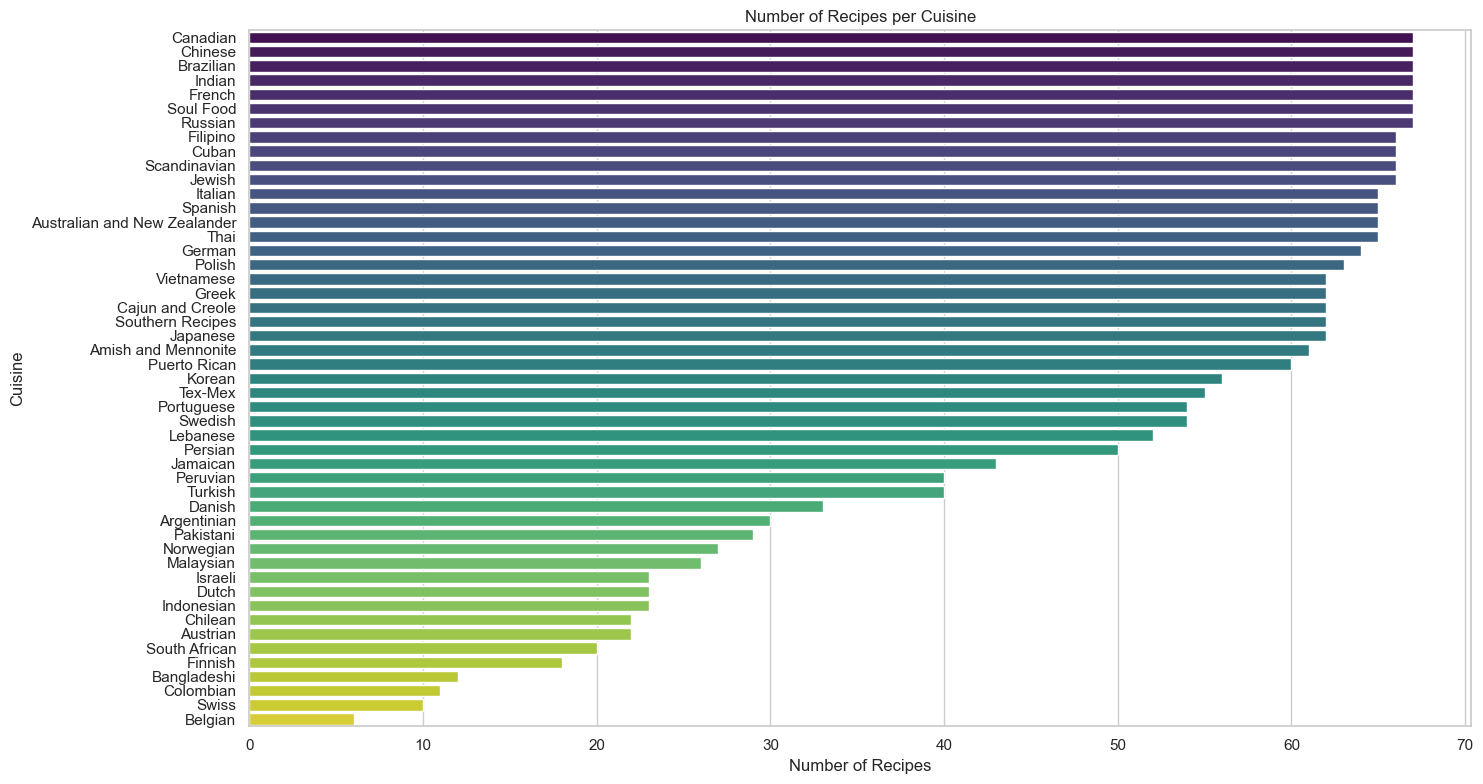


Cuisines with fewest recipes (Bottom 5):
cuisine
Finnish        18
Bangladeshi    12
Colombian      11
Swiss          10
Belgian         6
Name: count, dtype: int64


In [15]:
# EDA Cell 2: Cuisine Distribution
print("\n--- Cuisine Distribution ---")
cuisine_counts = df['cuisine'].value_counts()
print("Recipe Counts per Cuisine (Top 15):")
print(cuisine_counts.head(15))

plt.figure(figsize=(15, 8))
sns.barplot(y=cuisine_counts.index, x=cuisine_counts.values, palette="viridis")
plt.title('Number of Recipes per Cuisine')
plt.xlabel('Number of Recipes')
plt.ylabel('Cuisine')
plt.tight_layout()
plt.show()

print(f"\nCuisines with fewest recipes (Bottom 5):\n{cuisine_counts.tail()}")


--- Overall Ingredient Analysis ---

Distribution of Ingredient Counts per Recipe:
count    2330.000000
mean       10.718455
std         4.465858
min         2.000000
25%         7.000000
50%        10.000000
75%        13.000000
max        37.000000
Name: ingredient_count, dtype: float64


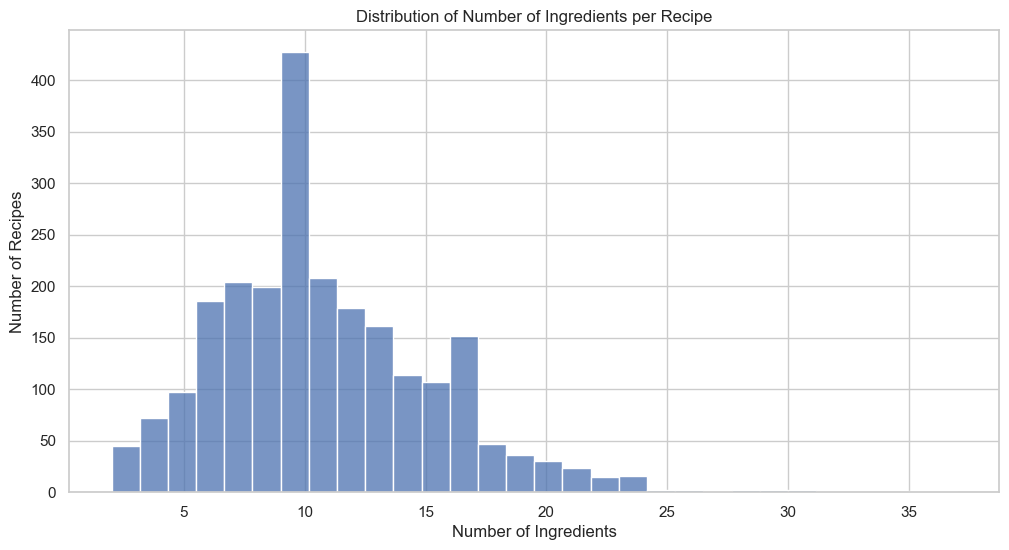


Top 20 Most Common Ingredients Overall:
ingredients
salt               1294
sugar              1157
water               839
onion               730
butter              690
egg                 629
flour               617
oil                 580
pepper              502
cloves garlic       463
olive oil           440
milk                331
tomato              254
vanilla extract     230
cinnamon            207
cayenne pepper      206
soy sauce           205
cumin               194
baking powder       183
garlic              177
Name: count, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_13780\3375976271.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=overall_ingredient_counts.head(n_top_ingredients).index,


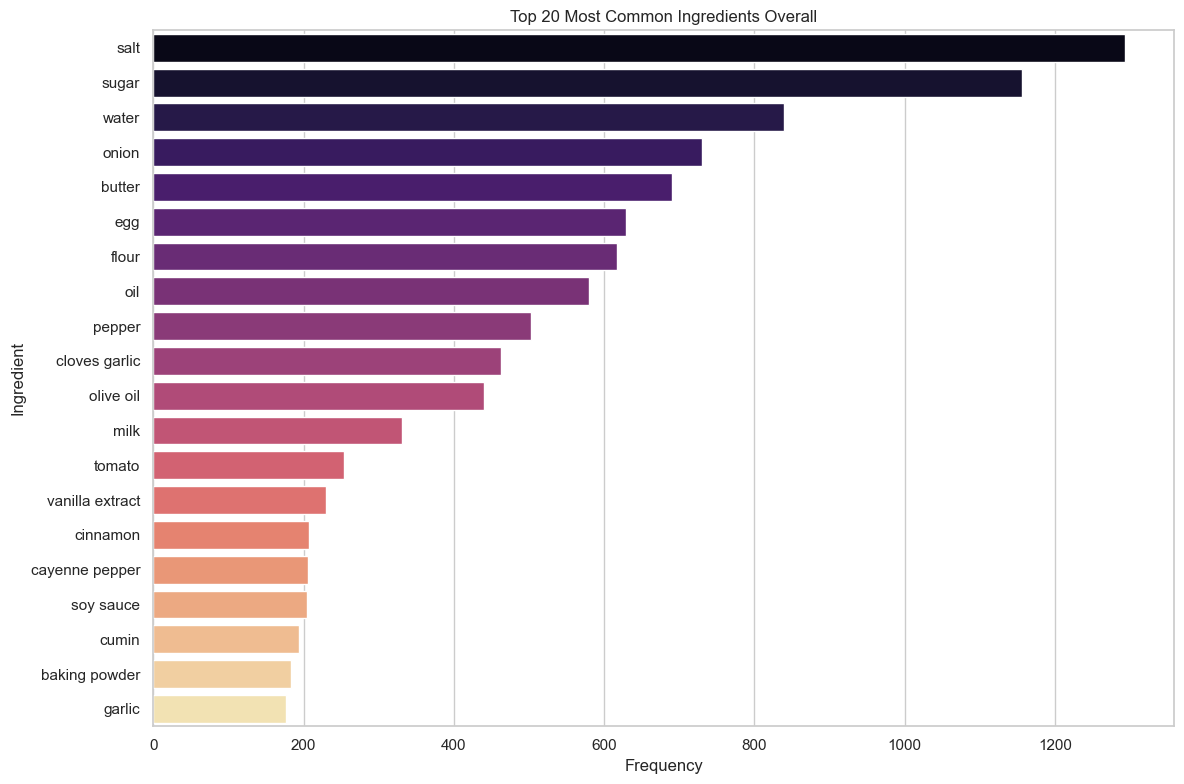

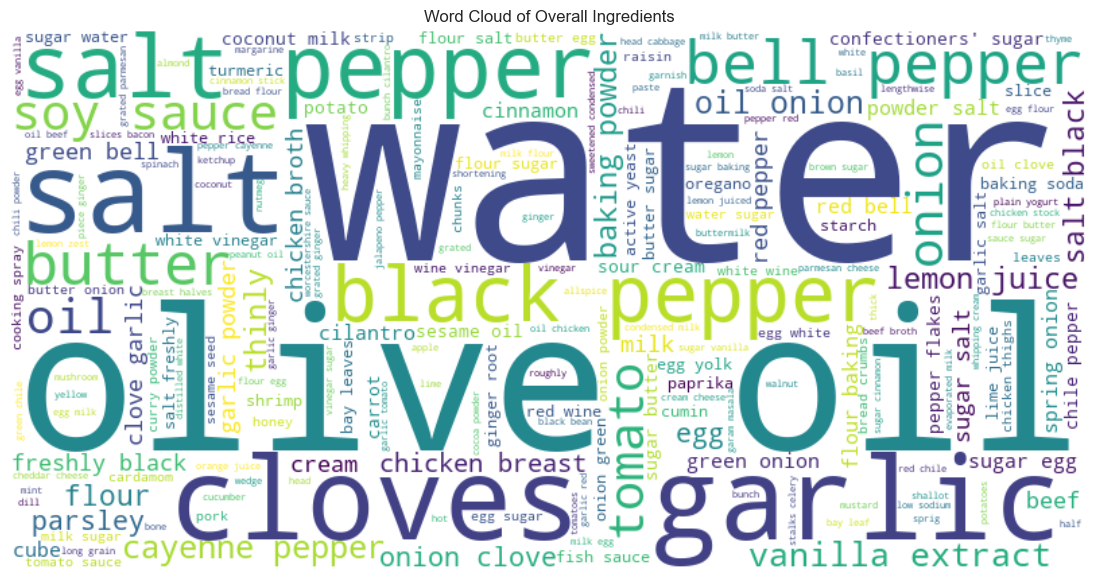

In [16]:
# EDA Cell 3: Ingredient Analysis (Overall)
print("\n--- Overall Ingredient Analysis ---")

# Calculate number of ingredients per recipe
df['ingredient_count'] = df['ingredients'].apply(len)

print("\nDistribution of Ingredient Counts per Recipe:")
print(df['ingredient_count'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(df['ingredient_count'], bins=30, kde=False)
plt.title('Distribution of Number of Ingredients per Recipe')
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Recipes')
plt.show()

# --- Top Overall Ingredients ---
# Explode the dataframe to have one ingredient per row
all_ingredients_exploded = df.explode('ingredients')['ingredients']

# Count ingredient frequencies
overall_ingredient_counts = all_ingredients_exploded.value_counts()

print("\nTop 20 Most Common Ingredients Overall:")
print(overall_ingredient_counts.head(20))

# Plot top N ingredients
n_top_ingredients = 20
plt.figure(figsize=(12, 8))
sns.barplot(y=overall_ingredient_counts.head(n_top_ingredients).index,
            x=overall_ingredient_counts.head(n_top_ingredients).values,
            palette="magma")
plt.title(f'Top {n_top_ingredients} Most Common Ingredients Overall')
plt.xlabel('Frequency')
plt.ylabel('Ingredient')
plt.tight_layout()
plt.show()

# --- Word Cloud for Overall Ingredients ---
if wordcloud_available:
    # Create a single string of all ingredients for the word cloud
    all_ingredients_text = ' '.join(all_ingredients_exploded.astype(str))

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_ingredients_text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Overall Ingredients')
    plt.show()


--- Ingredient Analysis Per Cuisine ---

Average Number of Ingredients per Cuisine (Top 10):
cuisine
Bangladeshi    15.000000
Pakistani      13.896552
Malaysian      13.576923
Indonesian     13.260870
Jamaican       13.232558
Indian         13.223881
Italian        12.769231
Vietnamese     12.677419
Belgian        12.500000
Thai           12.261538
Name: ingredient_count, dtype: float64


C:\Users\Admin\AppData\Local\Temp\ipykernel_13780\1426413903.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=avg_ingredients_per_cuisine.head(15).index,


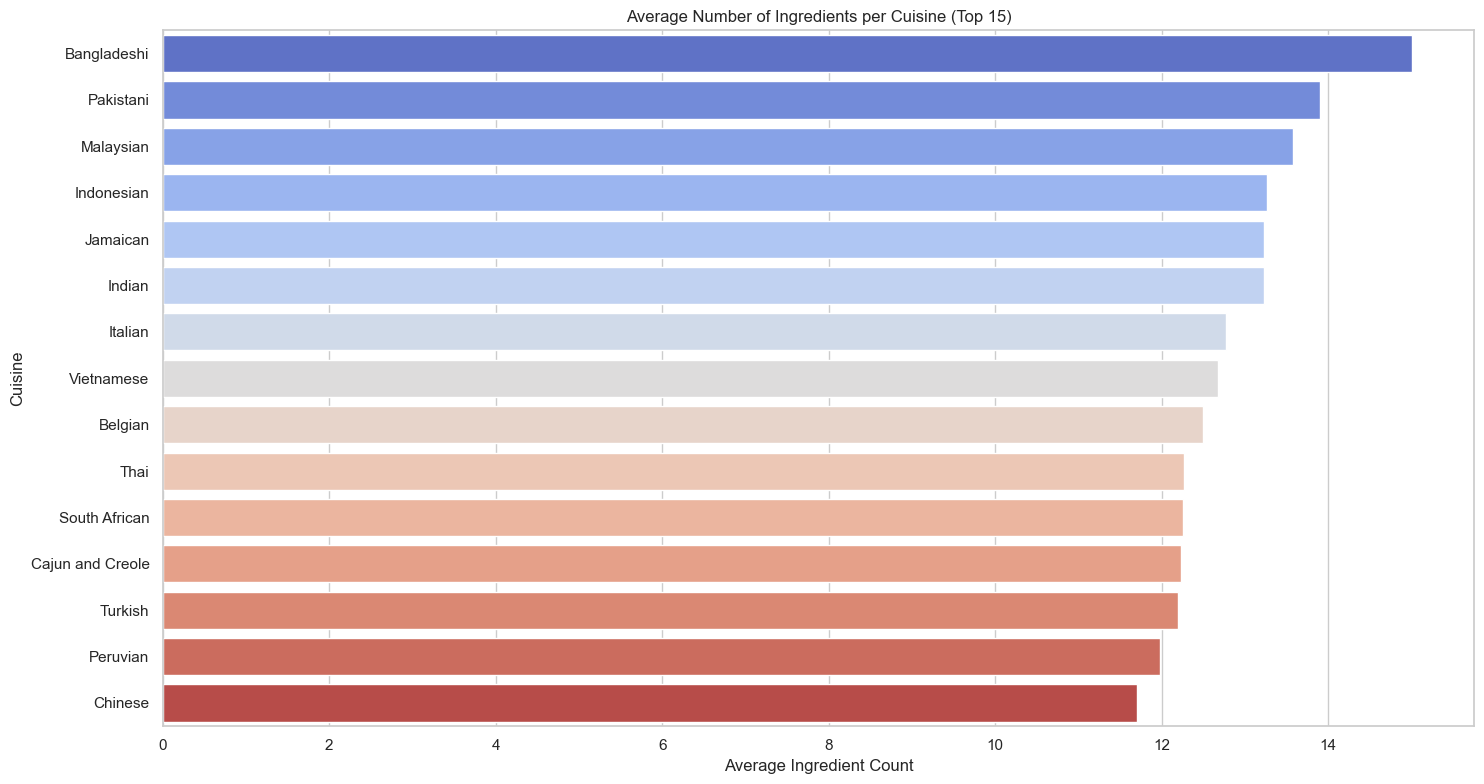


Top 10 Ingredients for Selected Cuisines: Canadian, Chinese, Brazilian, Indian, French


C:\Users\Admin\AppData\Local\Temp\ipykernel_13780\1426413903.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_cuisine_ingredients.index, x=top_cuisine_ingredients.values, ax=axes[i], palette="rocket")
C:\Users\Admin\AppData\Local\Temp\ipykernel_13780\1426413903.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_cuisine_ingredients.index, x=top_cuisine_ingredients.values, ax=axes[i], palette="rocket")
C:\Users\Admin\AppData\Local\Temp\ipykernel_13780\1426413903.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_cuisi

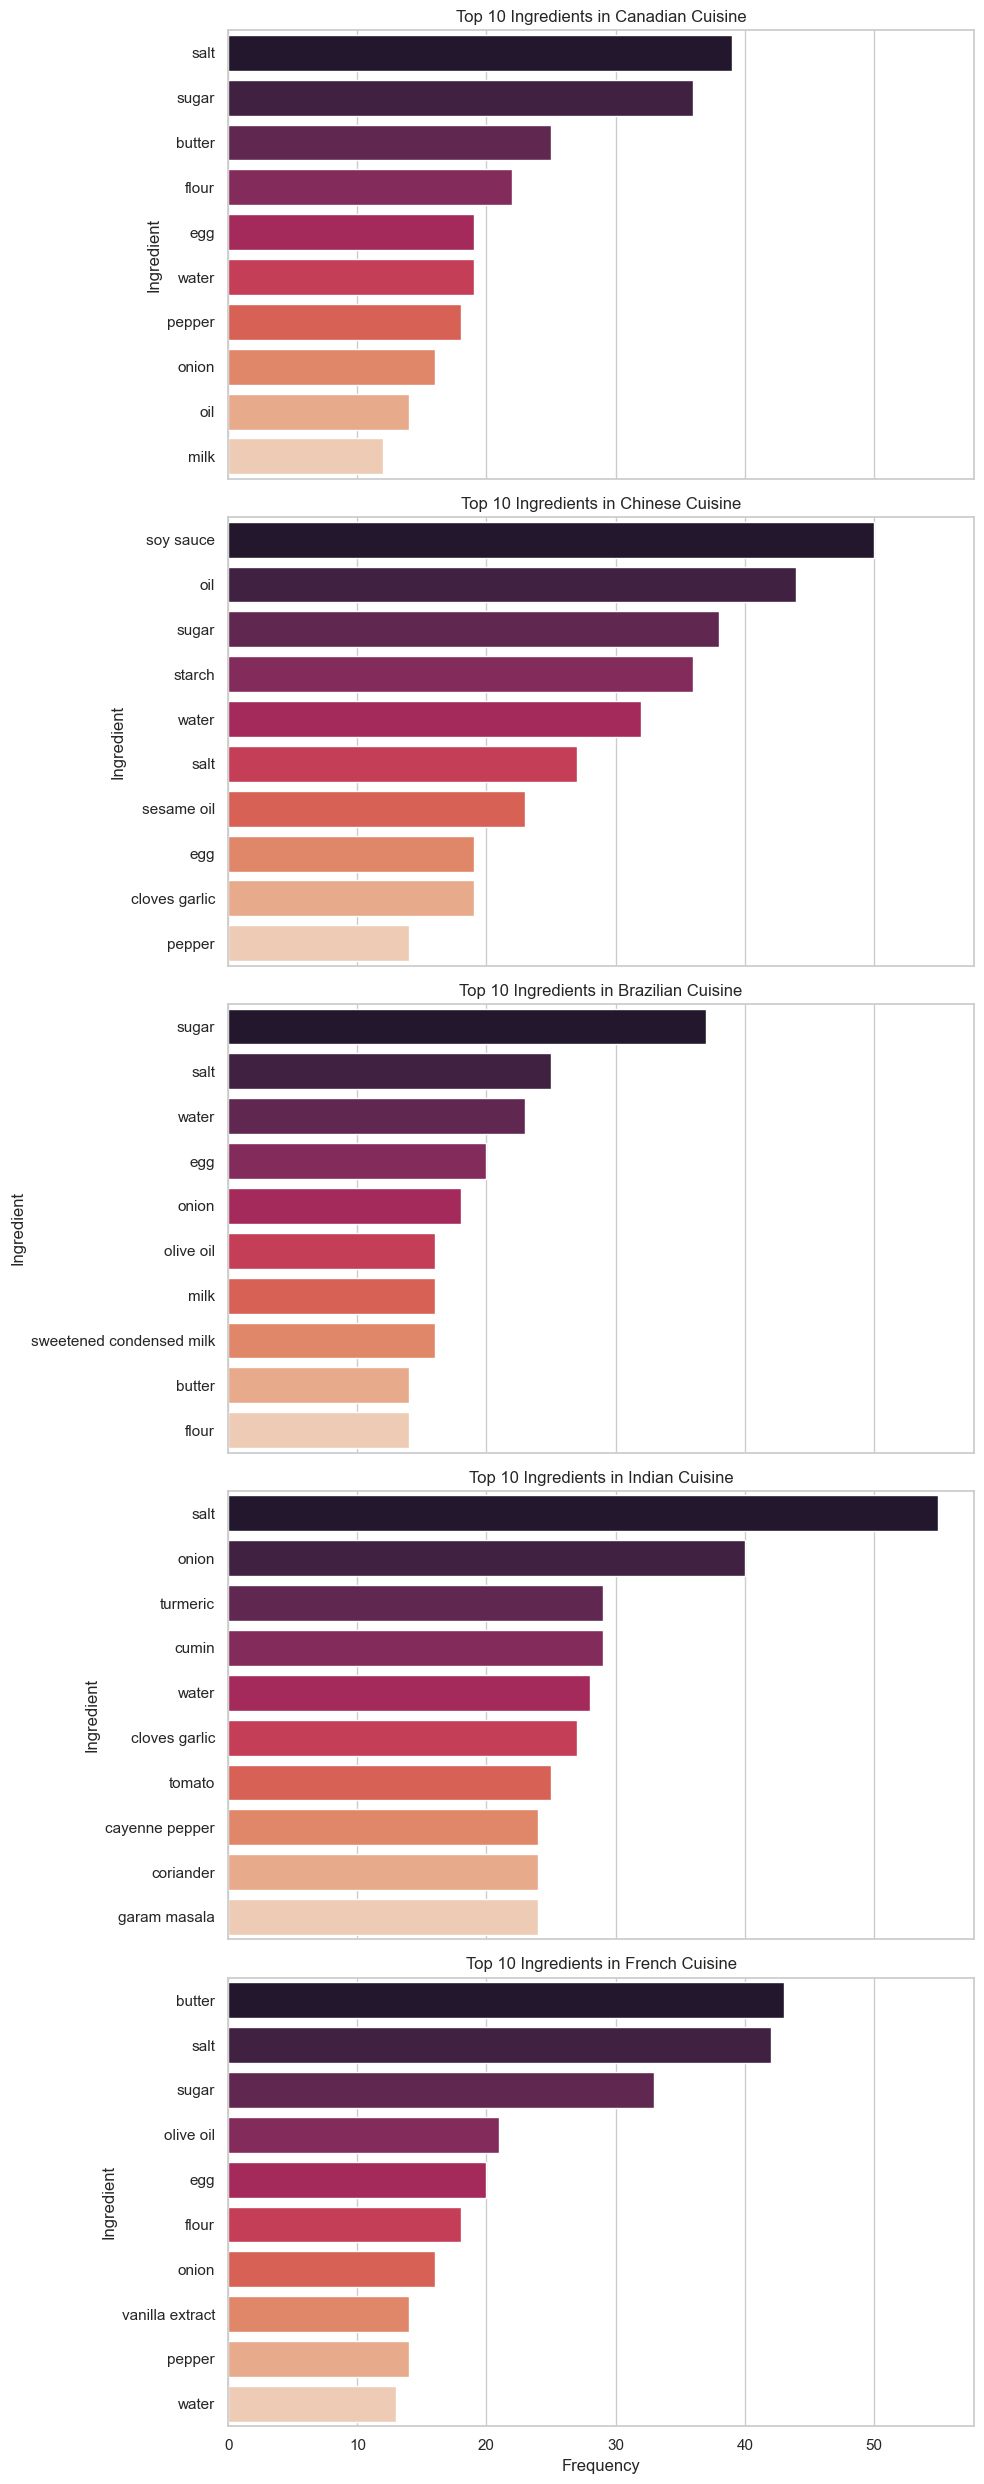


Word Clouds for Selected Cuisines: Canadian, Chinese, Brazilian, Indian, French


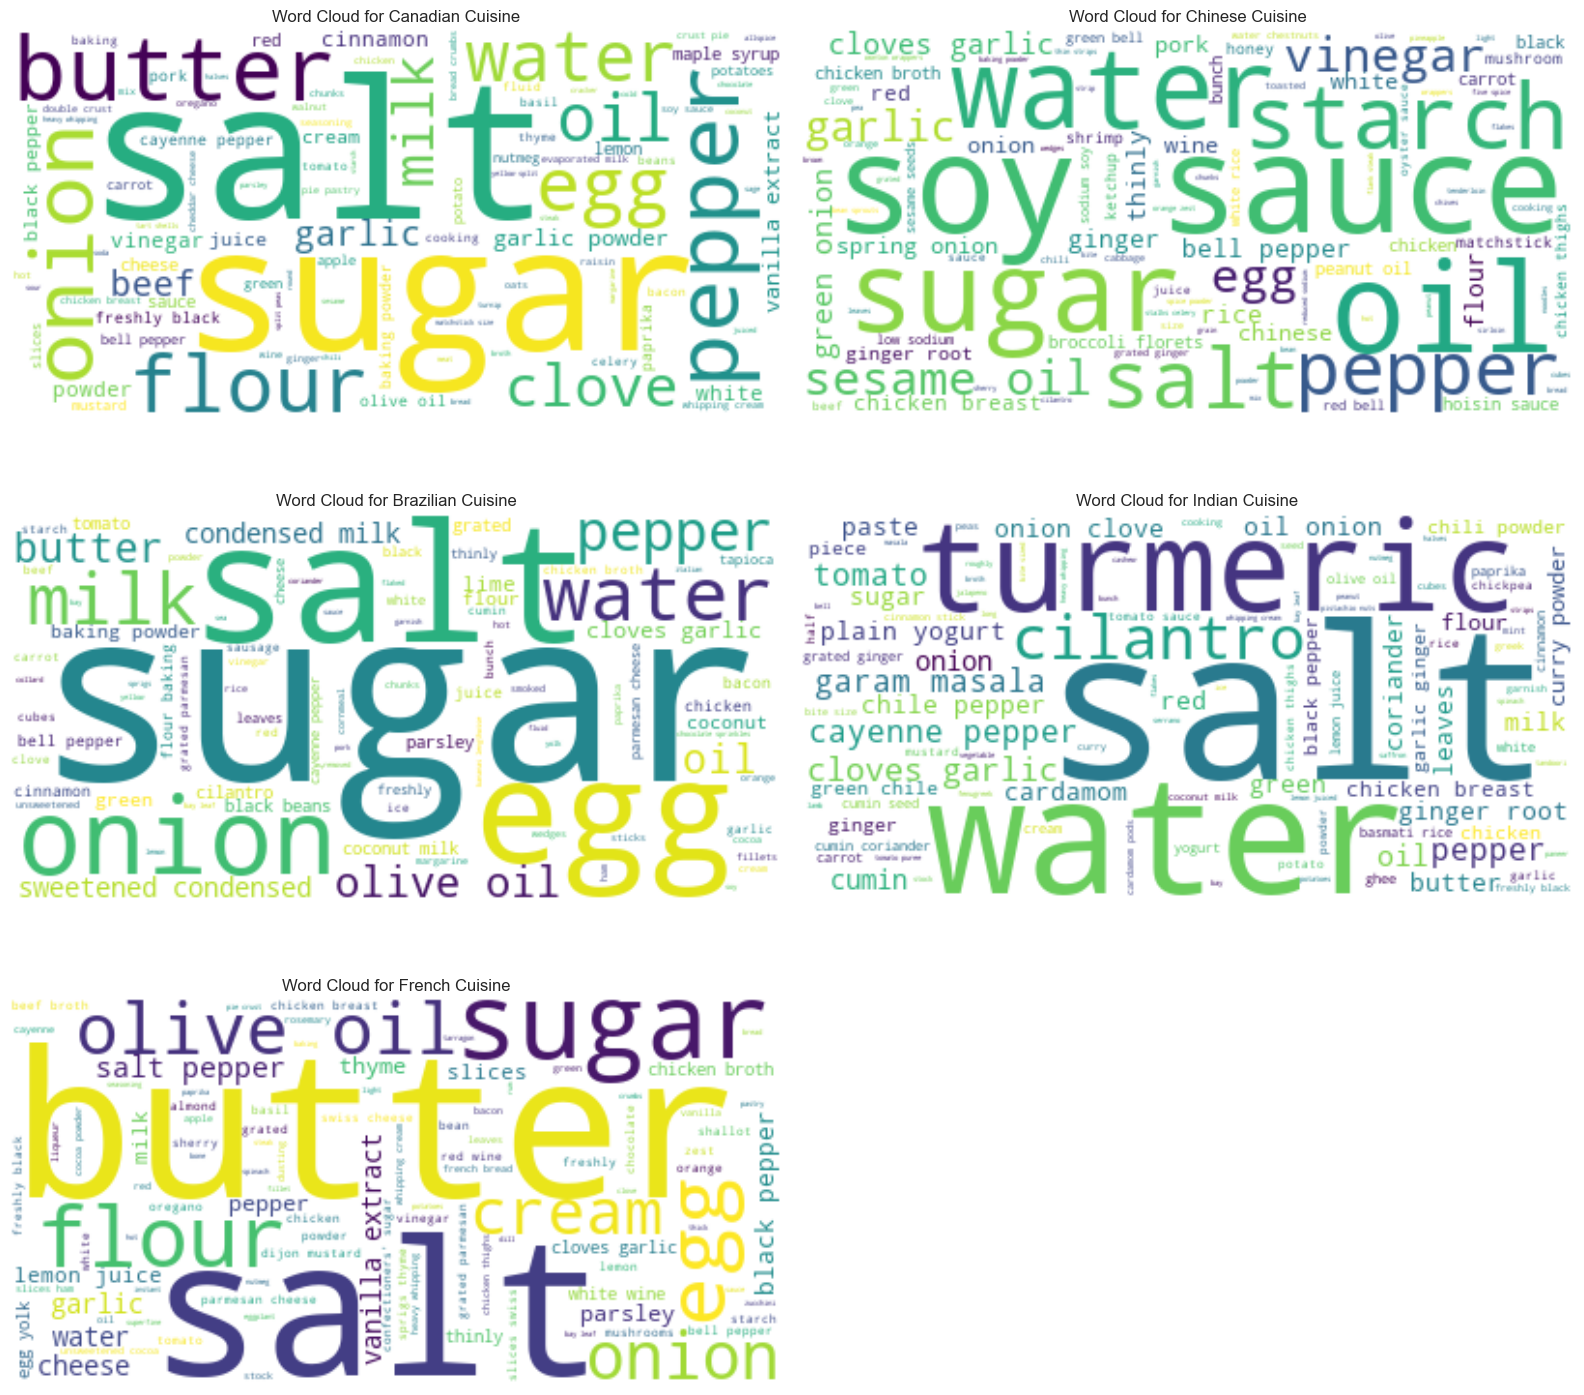

In [17]:
# EDA Cell 4: Ingredient Analysis (Per Cuisine)
print("\n--- Ingredient Analysis Per Cuisine ---")

# Calculate average number of ingredients per cuisine
avg_ingredients_per_cuisine = df.groupby('cuisine')['ingredient_count'].mean().sort_values(ascending=False)

print("\nAverage Number of Ingredients per Cuisine (Top 10):")
print(avg_ingredients_per_cuisine.head(10))

plt.figure(figsize=(15, 8))
sns.barplot(y=avg_ingredients_per_cuisine.head(15).index,
            x=avg_ingredients_per_cuisine.head(15).values,
            palette="coolwarm")
plt.title('Average Number of Ingredients per Cuisine (Top 15)')
plt.xlabel('Average Ingredient Count')
plt.ylabel('Cuisine')
plt.tight_layout()
plt.show()


# --- Top Ingredients for Specific Cuisines ---
# Let's look at a few cuisines with a decent number of recipes
cuisines_to_examine = cuisine_counts.head(5).index.tolist() # Top 5 cuisines by recipe count
# Or manually select some: cuisines_to_examine = ['Italian', 'Mexican', 'Indian', 'Chinese']

print(f"\nTop 10 Ingredients for Selected Cuisines: {', '.join(cuisines_to_examine)}")

fig, axes = plt.subplots(len(cuisines_to_examine), 1, figsize=(10, 5 * len(cuisines_to_examine)), sharex=True)
if len(cuisines_to_examine) == 1: # Handle case of single subplot
    axes = [axes]

for i, cuisine in enumerate(cuisines_to_examine):
    cuisine_ingredients = df[df['cuisine'] == cuisine].explode('ingredients')['ingredients']
    top_cuisine_ingredients = cuisine_ingredients.value_counts().head(10)

    sns.barplot(y=top_cuisine_ingredients.index, x=top_cuisine_ingredients.values, ax=axes[i], palette="rocket")
    axes[i].set_title(f'Top 10 Ingredients in {cuisine} Cuisine')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Ingredient')

plt.tight_layout()
plt.show()

# --- Word Clouds for Specific Cuisines ---
if wordcloud_available:
    print(f"\nWord Clouds for Selected Cuisines: {', '.join(cuisines_to_examine)}")
    num_cols = 2 # Adjust layout as needed
    num_rows = (len(cuisines_to_examine) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 5 * num_rows))
    axes = axes.flatten() # Flatten axes array for easy iteration

    for i, cuisine in enumerate(cuisines_to_examine):
        cuisine_ingredients_text = ' '.join(df[df['cuisine'] == cuisine].explode('ingredients')['ingredients'].astype(str))

        if cuisine_ingredients_text: # Check if there's text to generate cloud
             wordcloud = WordCloud(width=400, height=200, background_color='white').generate(cuisine_ingredients_text)
             axes[i].imshow(wordcloud, interpolation='bilinear')
             axes[i].set_title(f'Word Cloud for {cuisine} Cuisine')
        else:
             axes[i].text(0.5, 0.5, 'No ingredients found', horizontalalignment='center', verticalalignment='center')

        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


--- Ingredient Co-occurrence Analysis ---


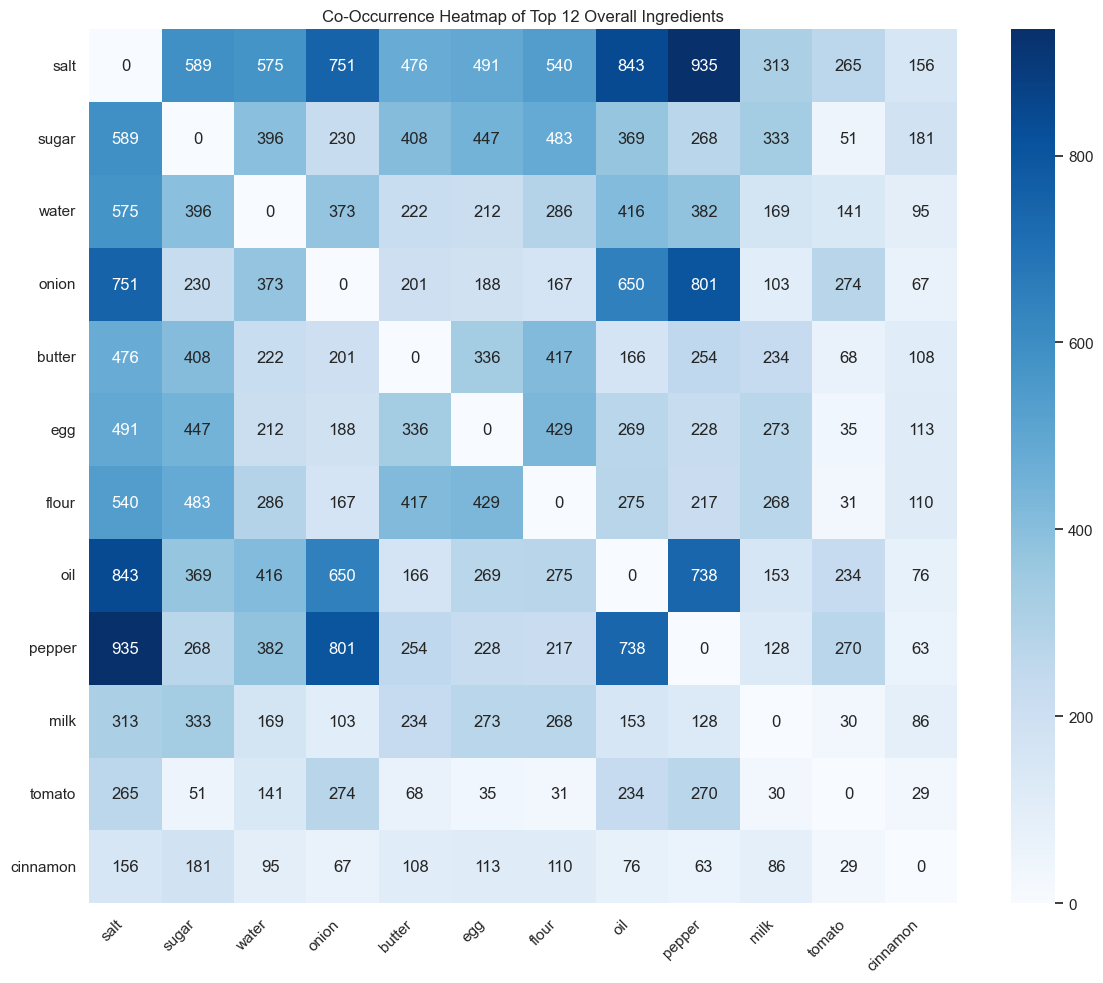


--- EDA Summary ---
- The dataset contains 2330 recipes across 49 cuisines.
- Cuisine distribution is uneven, with 'Canadian' being the most frequent (67 recipes) and 'Belgian' the least (6 recipes).
- Recipes typically contain between 7 and 13 ingredients (IQR), with a median of 10.
- The most common ingredients overall are: salt, sugar, water, onion, butter.
- Ingredient profiles vary significantly by cuisine (as seen in individual plots/clouds).
- Co-occurrence heatmap highlights common ingredient pairings across all recipes (e.g., salt & pepper, flour & sugar).


In [18]:
# EDA Cell 5: Ingredient Co-occurrence (Revisiting the heatmap)
print("\n--- Ingredient Co-occurrence Analysis ---")
# The co-occurrence matrix was already calculated in the preprocessing steps (variable: co_matrix_df)
# Let's visualize the heatmap for the top N overall ingredients for better readability

n_top_heatmap = 15 # Number of top ingredients to show in heatmap
top_overall_ingredients_list = overall_ingredient_counts.head(n_top_heatmap).index.tolist()

# Ensure only ingredients present in the matrix are selected
valid_top_ingredients = [ing for ing in top_overall_ingredients_list if ing in co_matrix_df.index]

if valid_top_ingredients:
    sub_matrix_top = co_matrix_df.loc[valid_top_ingredients, valid_top_ingredients]

    # Zero out the diagonal for better visualization of co-occurrences (optional)
    np.fill_diagonal(sub_matrix_top.values, 0)

    plt.figure(figsize=(12, 10))
    sns.heatmap(sub_matrix_top, cmap="Blues", annot=True, fmt=".0f")
    plt.title(f'Co-Occurrence Heatmap of Top {len(valid_top_ingredients)} Overall Ingredients')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Could not generate heatmap - no valid top ingredients found in co-occurrence matrix.")

print("\n--- EDA Summary ---")
print(f"- The dataset contains {len(df)} recipes across {df['cuisine'].nunique()} cuisines.")
print(f"- Cuisine distribution is uneven, with '{cuisine_counts.index[0]}' being the most frequent ({cuisine_counts.iloc[0]} recipes) and '{cuisine_counts.index[-1]}' the least ({cuisine_counts.iloc[-1]} recipes).")
print(f"- Recipes typically contain between {int(df['ingredient_count'].quantile(0.25))} and {int(df['ingredient_count'].quantile(0.75))} ingredients (IQR), with a median of {int(df['ingredient_count'].median())}.")
print(f"- The most common ingredients overall are: {', '.join(overall_ingredient_counts.head(5).index)}.")
print(f"- Ingredient profiles vary significantly by cuisine (as seen in individual plots/clouds).")
print(f"- Co-occurrence heatmap highlights common ingredient pairings across all recipes (e.g., salt & pepper, flour & sugar).")

end

In [117]:
# Get top ingredients after cleaning
from collections import Counter

all_ingredients = [ingredient for sublist in df["ingredients"] for ingredient in sublist]
ingredient_counts = Counter(all_ingredients)

# Only include ingredients that exist in the co-occurrence matrix
top_ingredient_names = [i for i, _ in ingredient_counts.most_common(20) if i in co_matrix_df.index]

# Extract sub-matrix
sub_matrix = co_matrix_df.loc[top_ingredient_names, top_ingredient_names]


In [118]:
# Count top ingredients per cuisine
top_ingredients_by_cuisine = df.explode("ingredients").groupby("cuisine")["ingredients"].value_counts().groupby(level=0).head(5)
print(top_ingredients_by_cuisine)


cuisine              ingredients  
Amish and Mennonite  sugar            55
                     salt             43
                     flour            38
                     egg              34
                     milk             29
                                      ..
Vietnamese           sugar            44
                     fish sauce       38
                     cloves garlic    31
                     water            31
                     oil              22
Name: count, Length: 245, dtype: int64


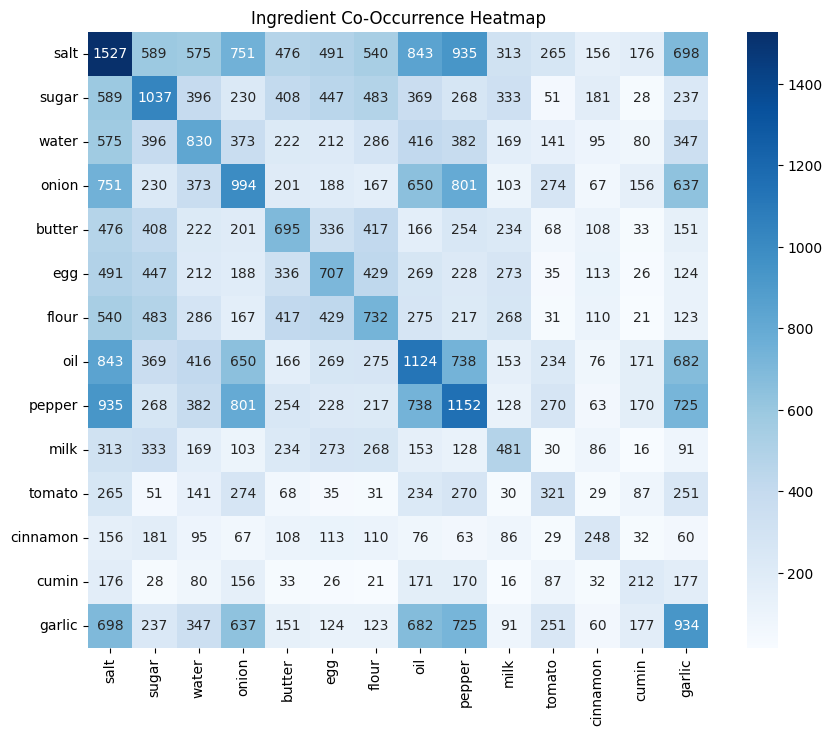

In [119]:
# Ensure only valid ingredients are used
valid_ingredients = [i for i in top_ingredient_names if i in co_matrix_df.index]

# Extract sub-matrix
sub_matrix = co_matrix_df.loc[valid_ingredients, valid_ingredients]

# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(sub_matrix, cmap="Blues", annot=True, fmt=".0f")
plt.title("Ingredient Co-Occurrence Heatmap")
plt.show()


In [120]:
output_file = 'clean_recipes_with_ingredients.json'
df.to_json(output_file, orient='records', lines=True)

print(f"DataFrame successfully saved to {output_file}")

DataFrame successfully saved to clean_recipes_with_ingredients.json


In [121]:
import json
from collections import defaultdict
import pandas as pd

# Load your JSON data (example structure shown below)
# [{"title": "Dutch Boterkoek", "ingredients": [...], "cuisine": "Dutch"}, ...]
with open('clean_recipes_with_ingredients.json') as f:
    recipes = [json.loads(line) for line in f]

# Step 1: Count ingredient co-occurrences per cuisine
co_occurrence = defaultdict(lambda: defaultdict(int))
ingredient_counts = defaultdict(int)

for recipe in recipes:
    cuisine = recipe['cuisine']
    ingredients = recipe['ingredients']

    # Update ingredient frequencies
    for ing in ingredients:
        ingredient_counts[(cuisine, ing)] += 1

    # Update co-occurrences
    for i in range(len(ingredients)):
        for j in range(i + 1, len(ingredients)):
            pair = tuple(sorted([ingredients[i], ingredients[j]]))
            co_occurrence[cuisine][pair] += 1

# Step 2: Build the hierarchy (D3.js-compatible JSON)
def build_hierarchy(co_occurrence, ingredient_counts):
    hierarchy = {"name": "cuisines", "children": []}

    for cuisine in set(r['cuisine'] for r in recipes):
        cuisine_node = {
            "name": cuisine,
            "children": [],
            "value": sum(v for (c, _), v in ingredient_counts.items() if c == cuisine)
        }

        # Add ingredients (leaf nodes)
        ingredients_in_cuisine = [
            ing for (c, ing), cnt in ingredient_counts.items()
            if c == cuisine
        ]

        for ing in ingredients_in_cuisine:
            cuisine_node["children"].append({
                "name": ing,
                "value": ingredient_counts[(cuisine, ing)],
                "cuisine": cuisine
            })

        hierarchy["children"].append(cuisine_node)

    return hierarchy

# Step 3: Add links between ingredients (for edge bundling)
def add_links(hierarchy, co_occurrence):
    links = []

    for cuisine in co_occurrence:
        for (ing1, ing2), weight in co_occurrence[cuisine].items():
            links.append({
                "source": ing1,
                "target": ing2,
                "value": weight,
                "cuisine": cuisine
            })

    return {
        "hierarchy": hierarchy,
        "links": links
    }

# Generate the final JSON
hierarchy = build_hierarchy(co_occurrence, ingredient_counts)
heb_data = add_links(hierarchy, co_occurrence)

# Save for D3.js
with open('data/heb_data.json', 'w') as f:
    json.dump(heb_data, f, indent=2)

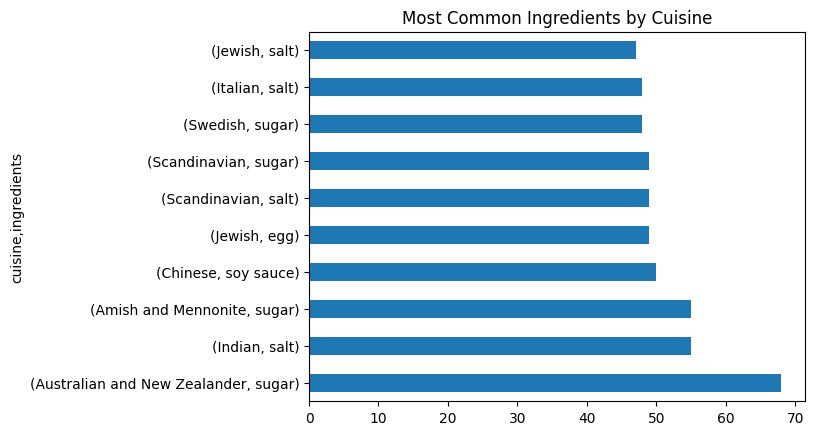

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_json('clean_recipes_with_ingredients.json', lines=True)

# Top 10 ingredients per cuisine
top_ingredients = (
    df.explode('ingredients')
    .groupby(['cuisine', 'ingredients']).size()
    .sort_values(ascending=False)
    .head(10)
)

top_ingredients.plot(kind='barh')
plt.title('Most Common Ingredients by Cuisine')
plt.show()